In [1]:
import torch                                  
import torch.nn as nn                        
import torch.nn.functional as F                
import numpy as np                            
import pandas as pd
import matplotlib.pyplot as plt
import time
import copy

%matplotlib inline

In [2]:
BATCH_SIZE = 1                              
LR = 0.001                                     
N_ACTIONS = 2                
N_STATES = 2       
episode = 260        
beta = 1          
T = 5              
N = 100            
dt = T / N
discount = 1
seed = 2023
number = 1
TAU = 0.1
sigma = 0.15
initial_point = torch.tensor((-1.0, 0.0))
terminal_point = torch.tensor((1.0, 0.0))
MEMORY_CAPACITY = int(N * number)                          
plt.rc('font', family='serif')
fontdict_prop = {'family': 'serif', 'size': 15}

In [3]:
def propagate(x, u):
    
    delta_x = drift(x, u) * dt

    return x + delta_x

def drift(x, u):

    y = x[0] - (x[0]) ** 3 - beta * x[0] * (x[1] ** 2)
    z = - (1 + x[0] ** 2) * x[1]
    x = torch.tensor((y, z))
    return x + u

def derivative(state):
    
    x = state[0]
    y = state[1]
    dx = 1 - 3 * x ** 2 - beta * y ** 2
    dy = - (1 + x ** 2)
    
    return dx + dy
    
def reward(x, u):     

    return (torch.sum(0.5 * torch.square(u)) / (sigma ** 2) + 0.5 * derivative(x)) * dt

def terminal_loss1(x, actor, index):
    
    s = x[0, :]
    y = terminal_point
    for i in range(N - index):
        a = actor(s)
        s_ = propagate(s, a)
        s = s_
    loss = nn.PairwiseDistance(p=2)(s, y)
    
    return loss

In [4]:
class Actor(nn.Module):
    def __init__(self, state_size, action_size):
        
        super(Actor, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.action_bound = 1
        self.linear1 = nn.Linear(self.state_size, 30)
        self.linear2 = nn.Linear(30, self.action_size)
        
    def forward(self, state):

        output = self.linear1(state)
        output = F.relu(output)
        output = self.linear2(output)
        output = torch.tanh(output) * self.action_bound
        
        return output

    
class Critic(nn.Module):
    def __init__(self, state_size, value_size):
        
        super(Critic, self).__init__()
        self.state_size = state_size
        self.linear1 = nn.Linear(self.state_size, 30)
        self.linear2 = nn.Linear(30, value_size)

    def forward(self, state):

        output = self.linear1(state)
        output = torch.arctan(output)
        output = self.linear2(output)
        
        return output

In [5]:
# 定义AC类 (定义两个网络)
class AC(object):
    def __init__(self):                                                         
        self.actor = Actor(N_STATES, N_ACTIONS)
        self.actor_target = Actor(N_STATES, N_ACTIONS)
        self.critic = Critic(N_ACTIONS + N_STATES, 1)
        self.critic_target = Critic(N_ACTIONS + N_STATES, 1)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.memory_counter = 0                                                 
        self.memory = torch.zeros((MEMORY_CAPACITY, 7))                           
        self.optimizer_actor = torch.optim.Adam(self.actor.parameters(), lr=LR)    
        self.optimizer_critic = torch.optim.Adam(self.critic.parameters(), lr=LR)

    def store_transition(self, s, a, r, s_):                                    
        transition = torch.cat((s.detach(), a.detach(), r.detach(), s_.detach()))  
        index = self.memory_counter % MEMORY_CAPACITY                           
        self.memory[index, :] = transition                                     
        self.memory_counter += 1                                                

    def learn(self, notion):                                                            
        tra = []
        for i in range(N):
            tra.append(self.memory[[N*j+i for j in range(number)]])
        sample_index = np.random.choice(number, BATCH_SIZE)                     
        b_memory = tra[notion][sample_index, :]                                 
        b_s = b_memory[:, :N_STATES]                  
        b_a = b_memory[:, N_STATES:N_STATES+2]
        b_r = b_memory[:, N_STATES+2:N_STATES+3]
        b_s_ = b_memory[:, -N_STATES:]
                
        if notion == N-1:
            Q_next = torch.tensor(0., requires_grad=True)
            for j in range(20):                
                Q_cur = self.critic(torch.cat((b_s, b_a), 1))                 
                td_error = b_r + discount * Q_next - Q_cur
                critic_loss = torch.mean(torch.square(td_error)) * 10000
                self.optimizer_critic.zero_grad()
                critic_loss.backward(retain_graph=True)
                self.optimizer_critic.step()

            Q_cur = self.critic(torch.cat((b_s, b_a), 1))
            td_error = b_r + discount * Q_next - Q_cur
            critic_loss = torch.mean(torch.square(td_error)) * 10000
            self.optimizer_critic.zero_grad()
            critic_loss.backward()
            self.optimizer_critic.step()
        
            for j in range(10):
                Q_cur = self.critic(torch.cat((b_s, self.actor(b_s)), 1)) 
                actor_loss_ = torch.mean(Q_cur) * 1
                terminal_loss = terminal_loss1(b_s, self.actor, notion) * 600
                actor_loss = actor_loss_ + terminal_loss

                self.optimizer_actor.zero_grad()
                actor_loss.backward(retain_graph=True)
                self.optimizer_actor.step()
            
            Q_cur = self.critic(torch.cat((b_s, self.actor(b_s)), 1)) 
            actor_loss_ = torch.mean(Q_cur) * 1
            terminal_loss = terminal_loss1(b_s, self.actor, notion) * 600
            actor_loss = actor_loss_ + terminal_loss

            self.optimizer_actor.zero_grad()
            actor_loss.backward()
            self.optimizer_actor.step()

        else:
            for j in range(1):
                Q_cur = self.critic(torch.cat((b_s, b_a), 1))
                Q_next = self.critic_target(torch.cat((b_s_, self.actor_target(b_s_)), 1))
                td_error = b_r + discount * Q_next - Q_cur
                critic_loss = torch.mean(torch.square(td_error)) * 10000
                self.optimizer_critic.zero_grad()
                critic_loss.backward(retain_graph=True)
                self.optimizer_critic.step()
                
            Q_cur = self.critic(torch.cat((b_s, b_a), 1))
            Q_next = self.critic_target(torch.cat((b_s_, self.actor_target(b_s_)), 1))
            td_error = b_r + discount * Q_next - Q_cur
            critic_loss = torch.mean(torch.square(td_error)) * 10000
            self.optimizer_critic.zero_grad()
            critic_loss.backward()
            self.optimizer_critic.step()

            Q_cur = self.critic(torch.cat((b_s, self.actor(b_s)), 1)) 
            actor_loss_ = torch.mean(Q_cur) * 1
            terminal_loss = terminal_loss1(b_s, self.actor, notion) * 600
            actor_loss = actor_loss_ + terminal_loss

            self.optimizer_actor.zero_grad()
            actor_loss.backward()
            self.optimizer_actor.step()
        
        self.soft_update(self.critic, self.critic_target, TAU)
        self.soft_update(self.actor, self.actor_target, TAU)   
        
        return critic_loss.detach().numpy(), actor_loss.detach().numpy(), actor_loss_.detach().numpy(), terminal_loss.detach().numpy()

    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0-tau) * target_param.data)

In [6]:
torch.manual_seed(seed)
ac = AC()   
x0 = initial_point
line = []
total_reward = []
loss_critic = []
loss_actor = []
loss_terminal = []

In [7]:
start_time = time.time()
for i in range(episode):                                                   
    print('<<<<<<<<<Episode: %s' % i)
    s = x0
    episode_reward_sum = 0

    for j in range(N): 
        
        a = ac.actor(s)
        a = torch.normal(a, 0.01)
        s_ = propagate(s, a)
        r = reward(s, a)
    
        ac.store_transition(s, a, r.reshape(-1), s_)                    
        episode_reward_sum += r.detach().numpy()           

        s = s_                                               

        if ac.memory_counter > MEMORY_CAPACITY:            
            critic_loss, actor_loss, actor_loss_, terminal_loss = ac.learn(j)
            
            loss_critic.append(np.around(critic_loss, 2))
            loss_actor.append(np.around(actor_loss, 2))
            loss_terminal.append(np.around(terminal_loss, 2))
            
        else:
            critic_loss = 0
            actor_loss = 0
            actor_loss_ = 0
            terminal_loss = 0

        if j == N - 1:       
            print('episode: %s --- reward_sum: %s --- critic_loss: %s --- actor_loss: %s --- actor_loss_: %s --- terminal_loss: %s' 
                  % (i, round(episode_reward_sum, 2),  np.around(critic_loss, 2), np.around(actor_loss, 2), np.around(actor_loss_, 2)
                    , np.around(terminal_loss, 2)))
            print(round(time.time() - start_time, 2))

    data = pd.DataFrame(ac.memory.detach().numpy())
    line.append(copy.deepcopy(data))
    total_reward.append(round(episode_reward_sum, 2))

<<<<<<<<<Episode: 0
episode: 0 --- reward_sum: 31.48 --- critic_loss: 0 --- actor_loss: 0 --- actor_loss_: 0 --- terminal_loss: 0
0.41
<<<<<<<<<Episode: 1
episode: 1 --- reward_sum: 63.46 --- critic_loss: 44024.12 --- actor_loss: 587.96 --- actor_loss_: 2.57 --- terminal_loss: 585.39
2.59
<<<<<<<<<Episode: 2
episode: 2 --- reward_sum: 33.6 --- critic_loss: 3326.11 --- actor_loss: 0.22 --- actor_loss_: -0.47 --- terminal_loss: 0.69
4.43
<<<<<<<<<Episode: 3
episode: 3 --- reward_sum: 31.03 --- critic_loss: 13.3 --- actor_loss: 0.67 --- actor_loss_: 0.06 --- terminal_loss: 0.62
6.27
<<<<<<<<<Episode: 4
episode: 4 --- reward_sum: 30.91 --- critic_loss: 0.47 --- actor_loss: 1.09 --- actor_loss_: 0.13 --- terminal_loss: 0.95
8.12
<<<<<<<<<Episode: 5
episode: 5 --- reward_sum: 30.84 --- critic_loss: 3.56 --- actor_loss: 1.38 --- actor_loss_: -0.0 --- terminal_loss: 1.39
9.92
<<<<<<<<<Episode: 6
episode: 6 --- reward_sum: 31.06 --- critic_loss: 141.32 --- actor_loss: 0.94 --- actor_loss_: 0.13

episode: 54 --- reward_sum: 31.81 --- critic_loss: 1056.87 --- actor_loss: 0.21 --- actor_loss_: 0.16 --- terminal_loss: 0.05
100.03
<<<<<<<<<Episode: 55
episode: 55 --- reward_sum: 32.49 --- critic_loss: 1751.17 --- actor_loss: 1.05 --- actor_loss_: 0.67 --- terminal_loss: 0.38
101.86
<<<<<<<<<Episode: 56
episode: 56 --- reward_sum: 32.35 --- critic_loss: 121.62 --- actor_loss: 0.73 --- actor_loss_: 0.13 --- terminal_loss: 0.61
103.68
<<<<<<<<<Episode: 57
episode: 57 --- reward_sum: 32.56 --- critic_loss: 176.7 --- actor_loss: 0.68 --- actor_loss_: 0.11 --- terminal_loss: 0.56
105.5
<<<<<<<<<Episode: 58
episode: 58 --- reward_sum: 32.37 --- critic_loss: 1438.93 --- actor_loss: 1.69 --- actor_loss_: 0.17 --- terminal_loss: 1.52
107.34
<<<<<<<<<Episode: 59
episode: 59 --- reward_sum: 32.41 --- critic_loss: 1268.33 --- actor_loss: 0.52 --- actor_loss_: 0.41 --- terminal_loss: 0.11
109.16
<<<<<<<<<Episode: 60
episode: 60 --- reward_sum: 32.0 --- critic_loss: 283.09 --- actor_loss: 1.22 --

episode: 108 --- reward_sum: 29.31 --- critic_loss: 198.3 --- actor_loss: 0.31 --- actor_loss_: -0.01 --- terminal_loss: 0.33
198.88
<<<<<<<<<Episode: 109
episode: 109 --- reward_sum: 29.02 --- critic_loss: 158.86 --- actor_loss: 0.96 --- actor_loss_: -0.03 --- terminal_loss: 0.99
200.7
<<<<<<<<<Episode: 110
episode: 110 --- reward_sum: 28.74 --- critic_loss: 229.45 --- actor_loss: 0.67 --- actor_loss_: -0.07 --- terminal_loss: 0.74
202.53
<<<<<<<<<Episode: 111
episode: 111 --- reward_sum: 28.83 --- critic_loss: 481.6 --- actor_loss: 0.73 --- actor_loss_: 0.1 --- terminal_loss: 0.62
204.36
<<<<<<<<<Episode: 112
episode: 112 --- reward_sum: 28.75 --- critic_loss: 280.01 --- actor_loss: 0.94 --- actor_loss_: 0.09 --- terminal_loss: 0.85
206.2
<<<<<<<<<Episode: 113
episode: 113 --- reward_sum: 28.72 --- critic_loss: 226.36 --- actor_loss: 0.5 --- actor_loss_: -0.11 --- terminal_loss: 0.6
208.04
<<<<<<<<<Episode: 114
episode: 114 --- reward_sum: 28.58 --- critic_loss: 492.49 --- actor_loss

episode: 161 --- reward_sum: 26.14 --- critic_loss: 246.23 --- actor_loss: 1.2 --- actor_loss_: -0.01 --- terminal_loss: 1.21
296.03
<<<<<<<<<Episode: 162
episode: 162 --- reward_sum: 26.19 --- critic_loss: 378.74 --- actor_loss: 0.7 --- actor_loss_: 0.06 --- terminal_loss: 0.64
297.85
<<<<<<<<<Episode: 163
episode: 163 --- reward_sum: 26.12 --- critic_loss: 380.91 --- actor_loss: 0.35 --- actor_loss_: 0.03 --- terminal_loss: 0.32
299.67
<<<<<<<<<Episode: 164
episode: 164 --- reward_sum: 26.09 --- critic_loss: 395.23 --- actor_loss: 0.41 --- actor_loss_: 0.07 --- terminal_loss: 0.34
301.52
<<<<<<<<<Episode: 165
episode: 165 --- reward_sum: 26.2 --- critic_loss: 311.94 --- actor_loss: 0.31 --- actor_loss_: 0.0 --- terminal_loss: 0.31
303.37
<<<<<<<<<Episode: 166
episode: 166 --- reward_sum: 26.04 --- critic_loss: 426.76 --- actor_loss: 0.22 --- actor_loss_: 0.08 --- terminal_loss: 0.13
305.21
<<<<<<<<<Episode: 167
episode: 167 --- reward_sum: 26.04 --- critic_loss: 377.14 --- actor_loss

episode: 215 --- reward_sum: 25.73 --- critic_loss: 374.56 --- actor_loss: 1.59 --- actor_loss_: 0.05 --- terminal_loss: 1.54
395.28
<<<<<<<<<Episode: 216
episode: 216 --- reward_sum: 25.68 --- critic_loss: 363.6 --- actor_loss: 0.6 --- actor_loss_: 0.05 --- terminal_loss: 0.55
397.11
<<<<<<<<<Episode: 217
episode: 217 --- reward_sum: 25.7 --- critic_loss: 367.02 --- actor_loss: 0.63 --- actor_loss_: 0.05 --- terminal_loss: 0.59
398.96
<<<<<<<<<Episode: 218
episode: 218 --- reward_sum: 25.66 --- critic_loss: 418.06 --- actor_loss: 0.54 --- actor_loss_: 0.06 --- terminal_loss: 0.48
400.79
<<<<<<<<<Episode: 219
episode: 219 --- reward_sum: 25.63 --- critic_loss: 399.62 --- actor_loss: 0.54 --- actor_loss_: 0.06 --- terminal_loss: 0.48
402.62
<<<<<<<<<Episode: 220
episode: 220 --- reward_sum: 25.78 --- critic_loss: 371.74 --- actor_loss: 0.36 --- actor_loss_: 0.06 --- terminal_loss: 0.29
404.45
<<<<<<<<<Episode: 221
episode: 221 --- reward_sum: 25.72 --- critic_loss: 364.56 --- actor_loss

In [8]:
w_x = 1.2
w_y = 0.4
y, x = np.mgrid[-0.5:0.5:20j, -w_x:w_x:20j] 
U = x-x**3-10*x*y**2
V = -(1+x**2)*y
speed = np.sqrt(U**2 + V**2) 

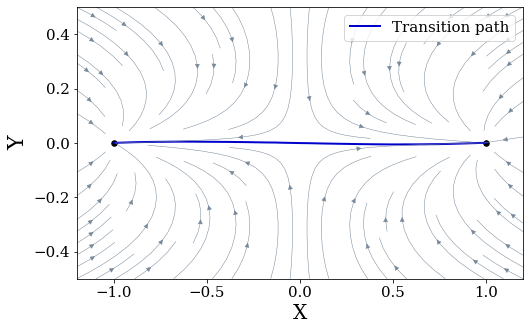

In [27]:
start = 210
end = 259
dd = line[start].copy(deep=True)
for num in range(start + 1, end + 1):
    dd += line[num] 
data = dd / (end - start + 1)

plt.figure(figsize=(8,5))
plt.plot(data.loc[:,0], data.loc[:, 1], color='mediumblue', label='Transition path', linewidth=2)
plt.streamplot(x, y, U, V, color = 'lightslategrey', linewidth = 0.5, density = 0.8) 
plt.scatter(-1, 0, color='black', s=30)
plt.scatter(1, 0, color='black', s=30)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylim(-0.5,0.5)
plt.xlabel('X', fontsize=20)
plt.ylabel('Y', fontsize=22)
plt.legend(prop=fontdict_prop, loc='upper right')
plt.savefig('beta = 1 plot.png',bbox_inches = 'tight', dpi=150)
plt.show()

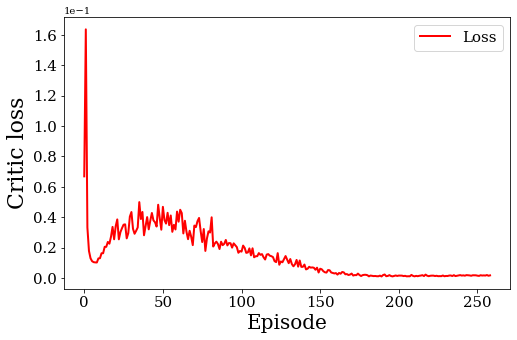

In [26]:
loss_mean = np.mean(np.array(loss_critic).reshape(-1, N), 1)
plt.figure(figsize=(8, 5))
plt.plot(range(len(loss_mean))[:260], loss_mean[:260]/10000, color='r', label='Loss', linewidth=2)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Critic loss', fontsize=22)
plt.ticklabel_format(axis='y', style='scientific', scilimits=(0,0))
plt.legend(prop=fontdict_prop)
plt.savefig('beta = 1 loss_critic.png',bbox_inches = 'tight', dpi=150)
plt.show()

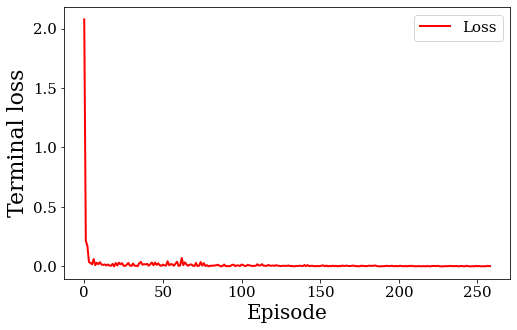

In [23]:
temp = np.array(loss_terminal).reshape(-1, N)
aa = []
for i in range(temp.shape[0]):
    aa.append(temp[i, 0])
ter = np.array(aa)/600
plt.figure(figsize=(8, 5))
plt.plot(range(len(aa))[:260], ter[:260], color='r', label='Loss', linewidth=2)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Terminal loss', fontsize=22)
plt.ticklabel_format(axis='y', style='scientific', scilimits=(0,0))
plt.legend(prop=fontdict_prop)
plt.savefig('beta = 1 terminal loss.png',bbox_inches = 'tight', dpi=150)
plt.show()

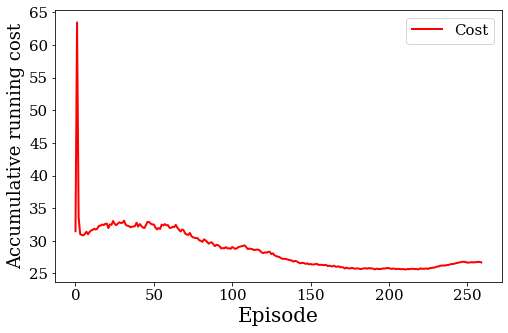

In [24]:
plt.figure(figsize=(8, 5))
plt.plot(total_reward[:260], color='r', label='Cost', linewidth=2)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Accumulative running cost', fontsize=18)
plt.legend(prop=fontdict_prop)
plt.savefig('beta = 1 cost.png',bbox_inches = 'tight', dpi=150)
plt.show()